# Question 1: Hot Dog or not Hot Dog?

We want to construct a prototype for an app that recognize if the provided image is an hot dog or not. 

First of all, we install and upload the packages

In [2]:
%matplotlib inline
from __future__ import print_function
import keras,sklearn
import tensorflow as tf
import numpy as np
import numpy.random
np.random.seed(42) # set arbitrary seed
seed = 42
tf.set_random_seed(seed)
import matplotlib.pyplot as plt
import time
import os
from scipy import ndimage, misc
import re
from matplotlib import cm
from skimage import color, exposure, transform
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
# num_classes = 2, 2 classes: hotdogs and not hotdogs

Then we write for preprocessing the images contained in the provided folders:

In [3]:
img_size = 80       # set image sizes

In [4]:
#function for preprocessing of images

def preprocess_img(image):
    # Histogram normalization
    hsv = color.rgb2hsv(image)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    image = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(image.shape[:-1])
    centre = image.shape[0] // 2, image.shape[1] // 2
    image = image[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale the image to standard size
    image = misc.imresize(image, (img_size, img_size))

    return image

and we import and  load the images of hotdog and not-hotdog by using the previous function of preprocessing, constructed in
the above cell:

In [5]:
#Upload images

cwd = os.getcwd() #find working directory                                                              

# Import hotdog images:

images = []                                                                    

for root, dirnames, filenames in os.walk(os.path.join(cwd, "hotdog/hotdog")): 
    for filename in filenames:                                          # loop over all image files in specified directory
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):                   
            filepath = os.path.join(root, filename)
            image=preprocess_img(ndimage.imread(filepath, mode="RGB"))  # read in image and preprocess
            images.append(image)                                        # insert at the end of the list
            
hotdog = np.array(images)                                               # put into an array


# Import not-hotdog images:

images = []

for root, dirnames, filenames in os.walk(os.path.join(cwd, "hotdog/not-hotdog")):
    for filename in filenames:                                          # loop over all image files in specified directory
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename)
            image=preprocess_img(ndimage.imread(filepath, mode="RGB"))  # read in image and preprocess
            images.append(image)                                        # insert at the end of the list
            
nothotdog = np.array(images)                                            # put into an array

now I load the pictures and put inside a matrix:

In [6]:
img_rows = 100   # standarise the images size
img_cols = 100   # standarise the images size
img_size = (img_rows,img_cols)

def load_pictures(path):
    subfolders = os.listdir(path)
    list_files = [path + "/" + i + "/" + j for i in subfolders for j in os.listdir(path + "/" + i)]    
    matrix = np.array([np.array(Image.open(list_files[i]).resize(img_size)) for i in range(len(list_files))])
    return matrix 

hotdog = load_pictures("./hotdog")
not_hotdog = load_pictures("./not-hotdog")

In [7]:
print(hotdog.shape, not_hotdog.shape)

(1856, 100, 100, 3) (3983, 100, 100, 3)


Joining in a single array the data of hotdogs and not-hotdogs and rescaling them in the interval [0,1]:

In [8]:
X = np.concatenate((hotdog,not_hotdog), axis=0)
X = X.astype('float32')/255

Now create an array, y, that takes into account the labels assigned to the data related to hotdogs (label=1) and the
data related to not-hotdog (label=0). The first 1856th entries of the vector y will be 1s and the remaining will be 0s:

In [9]:
num_samplesize = X.shape[0]
y = np.zeros(num_samplesize)
y[0:hotdog.shape[0]] = 1 # label
y

array([1., 1., 1., ..., 0., 0., 0.])

Now we split the data into training and test set, after having shuffled:

In [10]:
shuffle_index = np.arange(num_samplesize)
np.random.seed(seed)                       # using the same seed fixed in the first cell.
np.random.shuffle(shuffle_index)
train_size = np.int(num_samplesize*0.6)
test_size  = num_samplesize - train_size

# split data in training and test set. The labels contained in y have to be transformed to categorical values.
X_train = X[shuffle_index[0:train_size]]
y_train = keras.utils.to_categorical(y[shuffle_index[0:train_size]],2) # 2 is the number of classes: i.e. hotdog and not-hotdog

X_test  = X[shuffle_index[train_size:,]]
y_test = keras.utils.to_categorical(y[shuffle_index[train_size:]],2)   # 2 is the number of classes: i.e. hotdog and not-hotdog

In [11]:
print('The ratio in the training set is  ',np.sum(y_train[:,0])/np.sum(y_train),'\n')
print('The ratio in the test set, ',np.sum(y_test[:,0])/np.sum(y_test))

The ratio in the training set is   0.6777048 

The ratio in the test set,  0.68878424


# Define the deep neural network 

As suggested in the literature for image recognition, we use a convolutional neural network (which can be interpreted as a special case of a deep neural network). The hyperparameters are chosen according to the provided code in the coursework.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D,Activation,MaxPooling2D

def keras_model(input_Shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_Shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
      
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    return model

# Choose the Optimizer and the Cost Function

In [13]:
def compile_model(optimizer=keras.optimizers.Adam()):
    model = keras_model((img_rows,img_cols,3))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

# Train the model

In [14]:
start = time.time()
# training parameters
batch_size = 64
epochs = 10
# create the deep neural net
model_DNN = compile_model()
# train DNN and store training info in history
history = model_DNN.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(X_test, y_test))
end = time.time()

Train on 3503 samples, validate on 2336 samples
Epoch 1/10
3503/3503 [==============================] - 120s 34ms/step - loss: 0.5900 - acc: 0.6837 - val_loss: 0.5432 - val_acc: 0.7076

# Evaluate the Model Performance on the Unseen Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the evaluate() method.

2336/2336 [==============================] - 24s 10ms/step

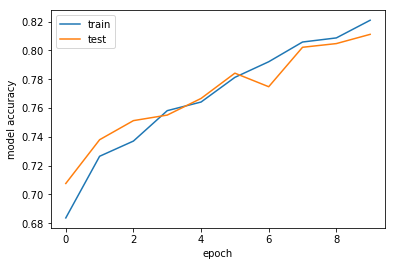

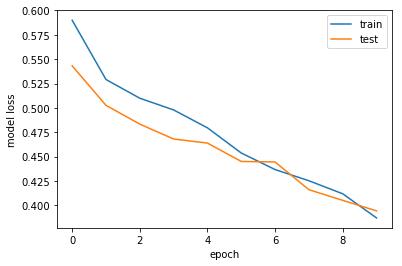

In [15]:
# evaluate the model
score = model_DNN.evaluate(X_test, y_test, verbose=1)

# print the performance of the model
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

The trained Convolutional Neural Network achieves an accuracy of approximately 80% on the given test data. In comparison, a random classifier would be expected to have an accuracy of around 50% (independent of the test data).

Now, we visualise three test images of both categories, hotdog and not-hotdog, and we use the model to yield a classification, mimicking the functioning of a real app.

The label for this image is hotdog
For the Convolutional Neural Network is hotdog


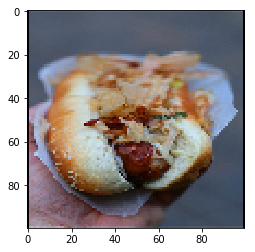

In [16]:
from matplotlib.pyplot import imshow
index = 10
imshow(X_test[index])
if(y_test[index][0] == 1):
    true_label = 'not-hotdog'
else:
    true_label = 'hotdog'
    
pred = model_DNN.predict_classes(X_test[index:index+1])

if(pred == 0):
    pred_label = 'not-hotdog'
else:
    pred_label = 'hotdog'
    
print('The label for this image is', true_label)
print('For the Convolutional Neural Network is', pred_label)

The label for this image is not-hotdog
For the Convolutional Neural Network is not-hotdog


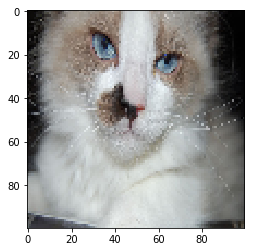

In [17]:
index = 91
imshow(X_test[index])
if(y_test[index][0] == 1):
    true_label = 'not-hotdog'
else:
    true_label = 'hotdog'
    
pred = model_DNN.predict_classes(X_test[index:index+1])

if(pred == 0):
    pred_label = 'not-hotdog'
else:
    pred_label = 'hotdog'
    
print('The label for this image is', true_label)
print('For the Convolutional Neural Network is', pred_label)

The label for this image is hotdog
For the Convolutional Neural Network is not-hotdog


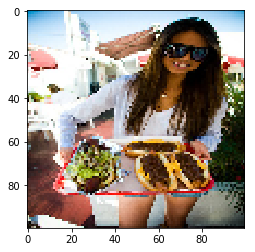

In [18]:
index = 56
imshow(X_test[index])
if(y_test[index][0] == 1):
    true_label = 'not-hotdog'
else:
    true_label = 'hotdog'
    
pred = model_DNN.predict_classes(X_test[index:index+1])

if(pred == 0):
    pred_label = 'not-hotdog'
else:
    pred_label = 'hotdog'
    
print('The label for this image is', true_label)
print('For the Convolutional Neural Network is', pred_label)